###### 

##### import tensorflow
tensorflow.__version__

----

## 6.300 Advanced recurrent neural networks

This subtopic reviews three advanced RNN techniques: 

- Recurrent dropout: to fight overfitting in recurrent layers.
- Stacking recurrent layers: to increase representational power
- Bidirectional recurrent layers: present information in different ways

The techniques are applied to a weather forecasting problem

----

## 6.310 Forcasting temperature

The IMDB dataset and the Reuters dataset are sequential text datasets

But sequence prediction is important in many other tasks apart from natural language processing

The Jena dataset comprises fourteen different quantities (air temperature, atmospheric pressure, humidity, wind direction...) recorded every ten minutes over several years at the Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/

We will build a model that uses the recent past (a few days worth of data points) to predicts the air temperature 24 hours in the future.

DLWP explains how to access Jena data 2009-2016

Unzip and inspect:

In [2]:
import os

data_dir = '/Users/timblackwell/Documents/Goldsmiths/2021/Data Science/data/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


Place the 420,551 lines of data into a Numpy array:

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

A plot of temperature (in Celsius) over time:

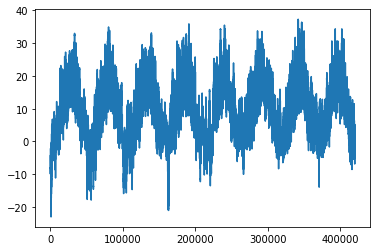

In [4]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

Temperature is periodic at long timescales

A fine grained plot (the first ten days)):

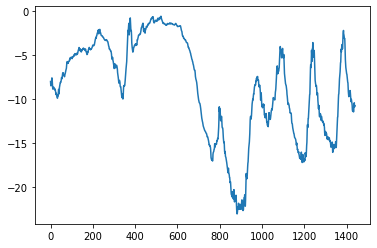

In [5]:
plt.plot(range(1440), temp[:1440])
plt.show()

It's fairly cold - must be winter

Daily periodicity is evident in the last four days

Predictions of average temperature for the next month given a few months of past data would be simple due to the 
reliable year-scale periodicity 

Daily data looks a lot more erratic

So is this timeseries predictable on a daily scale?

----

## 6.320 Data preparation

Formulation: 

given data going as far back as `lookback` timesteps (a timestep is 10 minutes) 

and sampled every `steps` timesteps, 

can we predict the temperature in `delay` timesteps?

Settings:

* `lookback = 720` - our observations will go back 5 days.
* `steps = 6` - our observations will be sampled at one data point per hour.
* `delay = 144` - our targets will be 24 hours in the future.

Preprocess:

Vectorisation is unnecessary because the data is already numerical

The timeseries in the data are on different scales (temperature between -20 and 30C, pressure is around 1000 mb) 

Each timeseries must be independently normalised so that they take small values on a similar scale

Subtracting the mean of each timeseries and dividing by the standard deviation for the training set - first 
200,000 timesteps 

In [6]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

The samples in our dataset are highly redundant - there is little change at a granularity of 10 minutes - it would be very wasteful to include all this information 

=> Use a python generator to stream samples on the fly from the original data

The generator takes our current array of float data and yields batches of data from the recent past and a target temperature in the future 



The data generator yields a tensor of shape `(samples, targets)` where `samples` is one batch of input data and 
`targets` is the corresponding array of target temperatures.

Arguments:

* `data`: The original array of floating point data, which we just normalized in the code snippet above.
* `lookback`: How many timesteps back should our input data go.
* `delay`: How many timesteps in the future should our target be.
* `min_index` and `max_index`: Indices in the `data` array that delimit which timesteps to draw from. This is useful for keeping a segment 
of the data for validation and another one for testing.
* `shuffle`: Whether to shuffle our samples or draw them in chronological order.
* `batch_size`: The number of samples per batch.
* `step`: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [7]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Three generators: training (first 200,000 timesteps, validation (the next 100,000) and testing (the remainder)

In [8]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [ ]:
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

----

## 6.330 Common sense baseline

As always, a sanity check! What does ML have to beat to be better than common sense?

For example, suppose the Dogs vs Cats was a very unbalanced dataset with 90% dogs and 10% cats

If we always predict 'dog' we will be right 90% of the time

So a neural network would have to achieve an accuracy of at least 0.9 

But what about continuous data, like temperature

The temperature 24 hours in the future is likely close to the temperature now

(Maybe a dubious assumption for UK weather!)

Calculate the Mean Absolute Error (MAE): 

In [9]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


The MAE of the normalised temperature data is 0.29

Translates to a MAE of the orginal data of `0.29 * temperature_std = 2.57` Celsius

Can we beat this baseline? 

----

## 6.340 A basic machine learning approach

A common sense baseline is essential - otherwise we cannot calibrate the performance of any model

An ML baseline - a simple, cheap model - is also useful

Are sophisticated models worth the extra computational effort?

Our baseline model is a two layer (plus flattening layer) fully-connected feedforward network

The final layer has a single unit without activation - this is a regression task

MAE is loss, so results are directly comparable to the common-sense baseline

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 9s 18ms/step - loss: 1.2443 - val_loss: 0.3620
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3924 - val_loss: 0.3358
Epoch 3/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2882 - val_loss: 0.3090
Epoch 4/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2678 - val_loss: 0.3230
Epoch 5/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2530 - val_loss: 0.3110
Epoch 6/20
500/500 [==============================] - 9s 19ms/step - loss: 0.2430 - val_loss: 0.3493
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2354 - val_loss: 0.3314
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2297 - val_loss: 0.3399
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2245 - val_loss: 0.3326
Epoch 10/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2204 - val_lo

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

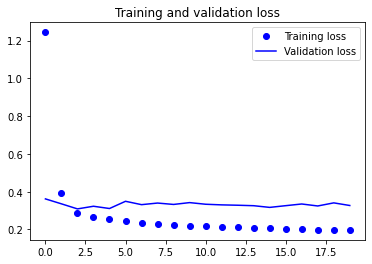

In [11]:
plt.show()

We haven't beaten the common sense baseline!

The model is worse than common sense

The machine is not privy to the wealth of human experiential evidence 

But why hasn't the machine found our simple model: that tomorrow's temperature will be pretty similar to today's? 


The hypothesis space is the space of all two layer networks 

Already a very complicated space

The simple baseline might hidden in a tiny corner of this vast, intricate hypothesis space 

ML limitation: parameter learning can fail to find a simple solution to a simple problem 

Of course we could hard-code models to look for a specific kind of solution but we wish to avoid excessive feature engineering 

----

## 6.350 A  recurrent baseline

The baseline model failed - but flattening removed time dependencies

Perhaps causality and order matter (weather is not actually random, but follows day-by-day patterns)  

Need an order-preserving model - an RNN

The `GRU` (gated recurrent unit) layer is a cheaper, but less powerful, LSTM 

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 63s 126ms/step - loss: 0.3026 - val_loss: 0.2743
Epoch 2/20
500/500 [==============================] - 60s 121ms/step - loss: 0.2852 - val_loss: 0.2688
Epoch 3/20
500/500 [==============================] - 61s 123ms/step - loss: 0.2803 - val_loss: 0.2633
Epoch 4/20
500/500 [==============================] - 61s 122ms/step - loss: 0.2756 - val_loss: 0.2652
Epoch 5/20
500/500 [==============================] - 62s 124ms/step - loss: 0.2729 - val_loss: 0.2705
Epoch 6/20
500/500 [==============================] - 61s 123ms/step - loss: 0.2663 - val_loss: 0.2636
Epoch 7/20
500/500 [==============================] - 62s 123ms/step - loss: 0.2618 - val_loss: 0.2647
Epoch 8/20
500/500 [==============================] - 62s 124ms/step - loss: 0.2580 - val_loss: 0.2736
Epoch 9/20
500/500 [==============================] - 62s 124ms/step - loss: 0.2523 - val_loss: 0.2677
Epoch 10/20
500/500 [==============================] - 62s 124ms/step - l

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

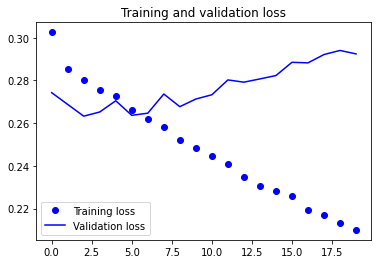

In [13]:
plt.show()

Success - the GRU modal (best MAE = 0.27) has beaten the common sense baseline prediction (MAE = 0.29)

The prediction is not spectacular - can we extend the model for better performance?

The plot shows overfitting

We should attempt to regularise the model

----

## 6.360 Recurrent dropout 

Dropout is the first-call regularisation technique (if we can't acquire more data)

Recurrent dropout is not obvious

Naive (a random dropout pattern at every timestep) dropout hinders learning 
 
Solution: apply the same pattern of dropped units at every timestep - a "recurrent" dropout mask).

The same dropout mask at every timestep helps learning error propagation through time - a temporally random dropout mask disrupts the error signal and is deleterious to learning

`tensorflow.keras` recurrent layer have two dropout arguments: 
    - `dropout`, a float specifying the dropout rate for input units 
    - `recurrent_dropout` specifying the dropout rate of the recurrent units

Add dropout and recurrent dropout to our GRU layer

Dropout regularised recurrent networks need more training - train our network for twice as many epochs

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 104s 208ms/step - loss: 0.3264 - val_loss: 0.2774
Epoch 2/40
500/500 [==============================] - 96s 193ms/step - loss: 0.3033 - val_loss: 0.2738
Epoch 3/40
500/500 [==============================] - 96s 193ms/step - loss: 0.2988 - val_loss: 0.2755
Epoch 4/40
500/500 [==============================] - 97s 194ms/step - loss: 0.2956 - val_loss: 0.2708
Epoch 5/40
500/500 [==============================] - 97s 194ms/step - loss: 0.2887 - val_loss: 0.2678
Epoch 6/40
500/500 [==============================] - 97s 195ms/step - loss: 0.2884 - val_loss: 0.2751
Epoch 7/40
500/500 [==============================] - 97s 194ms/step - loss: 0.2838 - val_loss: 0.2665
Epoch 8/40
500/500 [==============================] - 97s 195ms/step - loss: 0.2829 - val_loss: 0.2772
Epoch 9/40
500/500 [==============================] - 98s 195ms/step - loss: 0.2779 - val_loss: 0.2764
Epoch 10/40
500/500 [==============================] - 98s 196ms/step - 

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

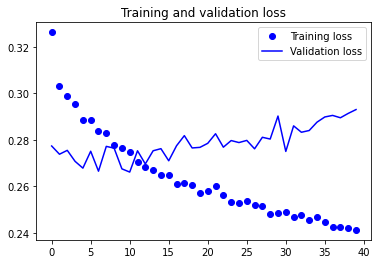

In [15]:
plt.show()

Still overfitting, but arguably not as severe

The dropout GRU has more stable validation MAEs but is not better than the previous unregularised GRU

----

## 6.370 Stacking recurrent layers

Overfitting has been ameliorated but have hit a performance bottleneck

Next: increase network capacity

Universal machine learning workflow: increase the network capacity whilst regularising until overfitting becomes your primary obstacle 

The model is under-capacity as long as it is not overfitting too badly

Network capacity is determined by the the number of units in the layers and the number layers

Recurrent layers can be stacked, just like dense layers

The Google translate algorithm is a stack of sixteen large LSTM layers

All intermediate layers should return their full sequence of outputs

Specify `return_sequences=True`: 

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True, 
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                    dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 243s 486ms/step - loss: 0.3181 - val_loss: 0.2812
Epoch 2/40
500/500 [==============================] - 238s 476ms/step - loss: 0.3034 - val_loss: 0.2834
Epoch 3/40
500/500 [==============================] - 239s 477ms/step - loss: 0.2934 - val_loss: 0.2812
Epoch 4/40
500/500 [==============================] - 238s 476ms/step - loss: 0.2864 - val_loss: 0.2677
Epoch 5/40
500/500 [==============================] - 242s 484ms/step - loss: 0.2782 - val_loss: 0.2728
Epoch 6/40
500/500 [==============================] - 235s 469ms/step - loss: 0.2738 - val_loss: 0.2725
Epoch 7/40
500/500 [==============================] - 233s 466ms/step - loss: 0.2675 - val_loss: 0.2707
Epoch 8/40
500/500 [==============================] - 235s 470ms/step - loss: 0.2628 - val_loss: 0.2824
Epoch 9/40
500/500 [==============================] - 234s 469ms/step - loss: 0.2571 - val_loss: 0.2859
Epoch 10/40
500/500 [==============================] - 233s 466m

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

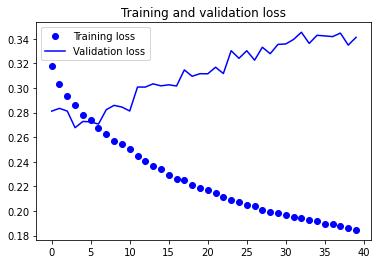

In [17]:
plt.show()

Overfitting is worse - the model is too big - and the best validation MAE is also not as good as the single GRU layer model

We could regularise more regressively

But perhaps we are seeing diminishing returns 

----

## 6.380 Bidirectional RNNs

A common RNN variant with higher performance than a regular RNN on certain tasks

Recommended for natural language processing

RNNs exploit patterns in data that has a definite order (like weather readings)

But the reverse of an ordered list is still ordered and might hold pertinent information

A bidirectional RNN is two regular RNNs 

One processes chronologically, the other antichronologically

Representations are subsequently merged

A bidirectional RNN is able to catch patterns that may have been overlooked by a single direction RNN

Let's try processing the Jena data in reverse order

What Is your prediction? Are data points in the distant past more informative than those in the recent past? 

Simply modify the data generator - replace the last line with `yield samples[:, ::-1, :], targets` 

In [18]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

Build and training the same one-GRU-layer network as before:

In [19]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen_reverse,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen_reverse,
                    validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 71s 143ms/step - loss: 0.4810 - val_loss: 0.4871
Epoch 2/20
500/500 [==============================] - 61s 121ms/step - loss: 0.4543 - val_loss: 0.4649
Epoch 3/20
500/500 [==============================] - 59s 118ms/step - loss: 0.3878 - val_loss: 0.4086
Epoch 4/20
500/500 [==============================] - 59s 118ms/step - loss: 0.3569 - val_loss: 0.4127
Epoch 5/20
500/500 [==============================] - 59s 118ms/step - loss: 0.3390 - val_loss: 0.4079
Epoch 6/20
500/500 [==============================] - 59s 119ms/step - loss: 0.3251 - val_loss: 0.3925
Epoch 7/20
500/500 [==============================] - 62s 124ms/step - loss: 0.3188 - val_loss: 0.3785
Epoch 8/20
500/500 [==============================] - 60s 120ms/step - loss: 0.3020 - val_loss: 0.3406
Epoch 9/20
500/500 [==============================] - 60s 119ms/step - loss: 0.2836 - val_loss: 0.3088
Epoch 10/20
500/500 [==============================] - 59s 119ms/step - l

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

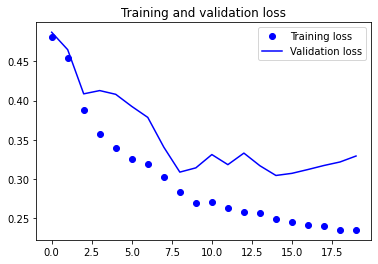

In [20]:
plt.show()

The reversed-order GRU strongly underperforms the common-sense baseline and the forward-order GRU 

Chronological processing is very important in this task

The GRU layer (like all RNNs) will be better at remembering the data it has just seen and clearly yesterday's weather is more salient of tomorrow's weather than the weather a week ago

But chronological ordering is not necessarily true for all timeseries (or otherwise ordered) tasks 

E.g. natural language: 'surfing went I' vs 'I went surfing' 

Let's try the LSTM IMDB example with reverse order movie reviews

In [ ]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Number of words to consider as features
max_features = 10000
# Cut texts after this number of words (among top max_features most common words)
maxlen = 500

# Load data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

In [1]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 39s 248ms/step - loss: 0.5408 - acc: 0.7261 - val_loss: 0.3662 - val_acc: 0.8522
Epoch 2/10
157/157 [==============================] - 36s 227ms/step - loss: 0.3305 - acc: 0.8709 - val_loss: 0.3787 - val_acc: 0.8424
Epoch 3/10
157/157 [==============================] - 33s 211ms/step - loss: 0.2712 - acc: 0.8996 - val_loss: 0.3076 - val_acc: 0.8824
Epoch 4/10
157/157 [==============================] - 35s 220ms/step - loss: 0.2439 - acc: 0.9150 - val_loss: 0.2996 - val_acc: 0.8884
Epoch 5/10
157/157 [==============================] - 34s 219ms/step - loss: 0.1994 - acc: 0.9280 - val_loss: 0.9988 - val_acc: 0.7702
Epoch 6/10
157/157 [==============================] - 34s 218ms/step - loss: 0.1829 - acc: 0.9382 - val_loss: 0.3788 - val_acc: 0.8406
Epoch 7/10
157/157 [==============================] - 34s 218ms/step - loss: 0.1601 - acc: 0.9437 - val_loss: 0.3749 - val_acc: 0.8830
Epoch 8/10
157/157 [==============================] - 3

The chronological-order LSTM also achieved about 88% validation accuracy

Reversed-order processing works just as well as chronological processing on the IMDB task

We hypothesise that word order *does* matter in understanding language but *which* order (forward or back)) isn't critical (on the basis if this single experiment) 

An RNN trained on a reversed sequence will learn different representations than one trained on the original sequence

Representations that are *different* yet *useful* are always worth exploiting

The more they differ the better!

Alternative representations can capture aspects of the data that were missed by other 
approaches

This is the intuition behind 'ensembling' (next topic)

A bidirectional RNN exploits this idea

![bidirectional rnn](https://s3.amazonaws.com/book.keras.io/img/ch6/bidirectional_rnn.png)

The bidirectional `tensorflow.keras` layer takes a recurrent layer instance as first argument 

`model.add(layers.Bidirectional(layers.LSTM(32)))`

and creates a second, separate instance of this recurrent layer

One instance for chronological processing, one for reverse processing

Let's try it on IMDB sentiment analysis

In [23]:
from tensorflow.keras import backend as K
K.clear_session()

In [24]:
model = Sequential()
model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 44s 282ms/step - loss: 0.5765 - acc: 0.7012 - val_loss: 0.4197 - val_acc: 0.8308
Epoch 2/10
157/157 [==============================] - 43s 272ms/step - loss: 0.3467 - acc: 0.8630 - val_loss: 0.3109 - val_acc: 0.8762
Epoch 3/10
157/157 [==============================] - 43s 272ms/step - loss: 0.2702 - acc: 0.9006 - val_loss: 0.3060 - val_acc: 0.8898
Epoch 4/10
157/157 [==============================] - 43s 271ms/step - loss: 0.2238 - acc: 0.9179 - val_loss: 0.7383 - val_acc: 0.8232
Epoch 5/10
157/157 [==============================] - 44s 277ms/step - loss: 0.2001 - acc: 0.9300 - val_loss: 0.3132 - val_acc: 0.8858
Epoch 6/10
157/157 [==============================] - 44s 280ms/step - loss: 0.1784 - acc: 0.9375 - val_loss: 0.3173 - val_acc: 0.8812
Epoch 7/10
157/157 [==============================] - 43s 271ms/step - loss: 0.1605 - acc: 0.9451 - val_loss: 0.3429 - val_acc: 0.8634
Epoch 8/10
157/157 [==============================] - 4

Slightly better than the regular LSTM we tried in the previous section

Overfits faster - a bidirectional layer has twice as many parameters 

A regularised bidirectional model would likely be a strong performer on this task

What about a bidirectional model for the weather prediction task?

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 75s 151ms/step - loss: 0.2941 - val_loss: 0.2685
Epoch 2/40
500/500 [==============================] - 73s 147ms/step - loss: 0.2723 - val_loss: 0.2623
Epoch 3/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2664 - val_loss: 0.2677
Epoch 4/40
500/500 [==============================] - 74s 149ms/step - loss: 0.2604 - val_loss: 0.2651
Epoch 5/40
500/500 [==============================] - 78s 156ms/step - loss: 0.2558 - val_loss: 0.2638
Epoch 6/40
500/500 [==============================] - 81s 163ms/step - loss: 0.2491 - val_loss: 0.2671
Epoch 7/40
500/500 [==============================] - 84s 167ms/step - loss: 0.2423 - val_loss: 0.2759
Epoch 8/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2359 - val_loss: 0.2753
Epoch 9/40
500/500 [==============================] - 77s 155ms/step - loss: 0.2296 - val_loss: 0.2899
Epoch 10/40
500/500 [==============================] - 78s 156ms/step - l

Comparable to the regular GRU layer

The chronological half of the network must be doing the important work because we know the antichronological half underperforms on the Jena data

----


## 6.390 Going further

Weather forecasting experiments:

* Adjust the number of units in each recurrent layer in the stacked model
* Adjust the learning rate used by the `RMSprop` optimiser
* `LSTM` layers instead of `GRU` layers

* Try a bigger densely-connected regressor on top of the recurrent layers, i.e. a stack of `Dense` layers.
* Remember to run the best performing models (in terms of validation MAE) on the test set (but don't fit to the test set)

There is currently no theory that will tell you the optimal model for any particular problem: trial, error and intuition

----

## 6.395 Wrapping up

- Always establish a common sense baseline

- Try simple models before expensive ones 

- Ordered data: recurrent networks outperform models that first flatten the temporal data

- Recurrent dropout: a time-constant dropout mask and recurrent dropout mask


- Stacked RNNs provide more representational power than a single RNN layer

    - they are also much more expensive, and thus not always worthwhile 
    - they offer clear gains on complex problems such as machine translation
    - they might not always be relevant on smaller, simpler problems

- Bidirectional RNNs, which look at a sequence both ways, are very useful on natural language processing problems 

    - They might not perform well on sequence data where the recent past is more informative than the distant past

----